In [2]:
import os
import datetime

import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Model, Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
#!pip install -q keras-tcn --no-dependencies
#from tcn import TCN, tcn_full_summary


from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras import initializers 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError 
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, SimpleRNN, LSTMCell, MaxPooling1D, Flatten, RepeatVector, GRU, Input

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df_path = '/content/drive/MyDrive/1min.csv'

# Load CSV file into a Pandas DataFrame
df = pd.read_csv(df_path)

In [5]:
# view summary statistics of dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
UNIX_sec,118123.0,1.529520e+09,1.048954e+07,1.512747e+09,1.519246e+09,1.529882e+09,1.537639e+09,1.548025e+09
ElevationAngle,118123.0,3.671553e+01,1.555254e+01,1.500000e+01,2.526883e+01,3.226930e+01,4.540940e+01,7.836703e+01
AzimuthAngle,118123.0,1.798533e+02,5.399173e+01,7.162534e+01,1.377247e+02,1.798011e+02,2.220086e+02,2.883586e+02
GSI_W/m^2,118123.0,4.997303e+02,2.480852e+02,9.481026e+00,3.054564e+02,4.883511e+02,6.707411e+02,1.263227e+03
Temperature_◦C,118123.0,1.721917e+01,1.019556e+01,-5.225932e+00,8.625206e+00,1.561113e+01,2.626812e+01,3.812885e+01
DewPoint_◦C,118123.0,-1.651166e+00,9.106979e+00,-3.527766e+01,-8.388889e+00,-2.994168e+00,5.422562e+00,1.727000e+01
AtmosphericPressure_mmHg,118123.0,7.652546e+02,4.056089e+00,7.503160e+02,7.627620e+02,7.655560e+02,7.678927e+02,7.767320e+02
WindDirection_radians,118123.0,3.517959e+00,1.309987e+00,0.000000e+00,2.705591e+00,3.703665e+00,4.356675e+00,6.265732e+00
WindVelocity_mile/s,118123.0,2.000713e+00,2.347106e+00,0.000000e+00,4.023360e-01,1.296416e+00,2.683143e+00,2.324419e+01
RelativeHumidity_%,118123.0,3.310109e+01,1.866100e+01,1.000000e+00,1.852584e+01,3.000000e+01,4.400000e+01,9.500000e+01


In [6]:
# view info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118123 entries, 0 to 118122
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UNIX_sec                  118123 non-null  float64
 1   ElevationAngle            118123 non-null  float64
 2   AzimuthAngle              118123 non-null  float64
 3   GSI_W/m^2                 118123 non-null  float64
 4   Temperature_◦C            118123 non-null  float64
 5   DewPoint_◦C               118123 non-null  float64
 6   AtmosphericPressure_mmHg  118123 non-null  float64
 7   WindDirection_radians     118123 non-null  float64
 8   WindVelocity_mile/s       118123 non-null  float64
 9   RelativeHumidity_%        118123 non-null  float64
 10  readable_datetime         118123 non-null  object 
dtypes: float64(10), object(1)
memory usage: 9.9+ MB


In [7]:
# sub-set of columns to be used for model training
df = df[['ElevationAngle', 'AzimuthAngle', 'GSI_W/m^2', 
        'Temperature_◦C', 'DewPoint_◦C', 'AtmosphericPressure_mmHg',
        'WindDirection_radians', 'WindVelocity_mile/s', 'RelativeHumidity_%', 
        'readable_datetime']]

In [8]:
# change readable_datetime to datetime64 data type
df['readable_datetime'] = pd.to_datetime(df['readable_datetime'], infer_datetime_format=True)

<ipython-input-8-65cda8f6fcb4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['readable_datetime'] = pd.to_datetime(df['readable_datetime'], infer_datetime_format=True)


In [9]:
# set readable_datetime as row index
df.set_index(df.readable_datetime,inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118123 entries, 2017-12-08 08:36:04 to 2019-01-20 15:50:00
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ElevationAngle            118123 non-null  float64       
 1   AzimuthAngle              118123 non-null  float64       
 2   GSI_W/m^2                 118123 non-null  float64       
 3   Temperature_◦C            118123 non-null  float64       
 4   DewPoint_◦C               118123 non-null  float64       
 5   AtmosphericPressure_mmHg  118123 non-null  float64       
 6   WindDirection_radians     118123 non-null  float64       
 7   WindVelocity_mile/s       118123 non-null  float64       
 8   RelativeHumidity_%        118123 non-null  float64       
 9   readable_datetime         118123 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(9)
memory usage: 9.9 MB


## Feature engineering 

In [11]:
# Convert to radians.
df['ElevationAngle_rad'] = df['ElevationAngle']*np.pi / 180
df['AzimuthAngle_rad'] = df['AzimuthAngle']*np.pi / 180

In [12]:
# Calculate the wind x and y components.
df['ElevationAngle_cos'] = np.cos(df['ElevationAngle_rad'])
df['ElevationAngle_sin'] = np.sin(df['ElevationAngle_rad'])
df['AzimuthAngle_sin'] = np.cos(df['AzimuthAngle_rad'])
df['AzimuthAngle_cos'] = np.sin(df['AzimuthAngle_rad'])
df['WindDirection_radians_cos'] = np.cos(df['WindDirection_radians'])
df['WindDirection_radians_sin'] = np.sin(df['WindDirection_radians'])

In [13]:
df.head()

,ElevationAngle,AzimuthAngle,GSI_W/m^2,Temperature_◦C,DewPoint_◦C,AtmosphericPressure_mmHg,WindDirection_radians,WindVelocity_mile/s,RelativeHumidity_%,readable_datetime,ElevationAngle_rad,AzimuthAngle_rad,ElevationAngle_cos,ElevationAngle_sin,AzimuthAngle_sin,AzimuthAngle_cos,WindDirection_radians_cos,WindDirection_radians_sin
readable_datetime,,,,,,,,,,,,,,,,,,
2017-12-08 08:36:04,15.000023,132.825735,247.350955,-1.412616,-10.952546,770.073760,1.909132,0.507345,48.213543,2017-12-08 08:36:04,0.261800,2.318246,0.965926,0.258819,-0.679771,0.733425,-0.331917,0.943309
2017-12-08 08:37:00,15.137937,132.992499,247.783427,-1.401186,-10.975406,770.099889,2.149721,0.456758,48.110672,2017-12-08 08:37:00,0.264207,2.321157,0.965300,0.261144,-0.681903,0.731443,-0.547124,0.837052
2017-12-08 08:38:00,15.286575,133.173234,251.524191,-1.388961,-11.000060,770.128000,2.408999,0.402635,48.000000,2017-12-08 08:38:00,0.266801,2.324311,0.964619,0.263647,-0.684206,0.729288,-0.743443,0.668800
2017-12-08 08:39:00,15.434081,133.353636,252.733730,-1.404770,-11.013234,770.128000,2.506673,0.468360,48.000000,2017-12-08 08:39:00,0.269376,2.327460,0.963937,0.266130,-0.686499,0.727130,-0.805120,0.593113
2017-12-08 08:40:00,15.581838,133.535402,255.725885,-1.420652,-11.026469,770.128000,2.604800,0.534389,48.000000,2017-12-08 08:40:00,0.271954,2.330632,0.963248,0.268614,-0.688803,0.724949,-0.859353,0.511382


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118123 entries, 2017-12-08 08:36:04 to 2019-01-20 15:50:00
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ElevationAngle             118123 non-null  float64       
 1   AzimuthAngle               118123 non-null  float64       
 2   GSI_W/m^2                  118123 non-null  float64       
 3   Temperature_◦C             118123 non-null  float64       
 4   DewPoint_◦C                118123 non-null  float64       
 5   AtmosphericPressure_mmHg   118123 non-null  float64       
 6   WindDirection_radians      118123 non-null  float64       
 7   WindVelocity_mile/s        118123 non-null  float64       
 8   RelativeHumidity_%         118123 non-null  float64       
 9   readable_datetime          118123 non-null  datetime64[ns]
 10  ElevationAngle_rad         118123 non-null  float64       
 11  AzimuthAngle_rad  

In [15]:
df = df[['readable_datetime', 'ElevationAngle_cos', 'ElevationAngle_sin', 
         'WindDirection_radians_cos', 'WindDirection_radians_sin', 'GSI_W/m^2', 'Temperature_◦C', 
         'DewPoint_◦C', 'AtmosphericPressure_mmHg', 'WindVelocity_mile/s', 'RelativeHumidity_%']]

#### Time

In [16]:
# save date_time object from readable_datetime with specified format
date_time = pd.to_datetime(df.pop('readable_datetime'), format='%d.%m.%Y %H:%M:%S')

In [17]:
# cocnvert date_time object to seconds and save in dataframe
df['timestamp_s'] = date_time.map(pd.Timestamp.timestamp)

In [18]:
day = 24*60*60
week = 24*60*60*7
month = 24*60*60*30
year = (365.2425)*day

df['Day sin'] = np.sin(df['timestamp_s'] * (2 * np.pi / day))
df['Day cos'] = np.cos(df['timestamp_s'] * (2 * np.pi / day))
#df['Week sin'] = np.sin(df['timestamp_s'] * (2 * np.pi / week))
#df['Week cos'] = np.cos(df['timestamp_s'] * (2 * np.pi / week))
# df['Month sin'] = np.sin(df['timestamp_s'] * (2 * np.pi / month))
# df['Month cos'] = np.cos(df['timestamp_s'] * (2 * np.pi / month))
df['Year sin'] = np.sin(df['timestamp_s'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['timestamp_s'] * (2 * np.pi / year))

In [19]:
df.head(2)

,ElevationAngle_cos,ElevationAngle_sin,WindDirection_radians_cos,WindDirection_radians_sin,GSI_W/m^2,Temperature_◦C,DewPoint_◦C,AtmosphericPressure_mmHg,WindVelocity_mile/s,RelativeHumidity_%,timestamp_s,Day sin,Day cos,Year sin,Year cos
readable_datetime,,,,,,,,,,,,,,,
2017-12-08 08:36:04,0.965926,0.258819,-0.331917,0.943309,247.350955,-1.412616,-10.952546,770.073760,0.507345,48.213543,1.512722e+09,0.776963,-0.629546,-0.389887,0.920863
2017-12-08 08:37:00,0.965300,0.261144,-0.547124,0.837052,247.783427,-1.401186,-10.975406,770.099889,0.456758,48.110672,1.512722e+09,0.774393,-0.632705,-0.389876,0.920867


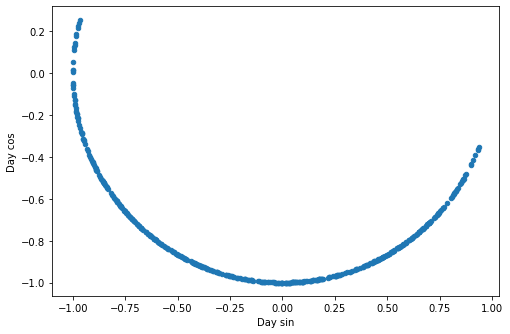

In [20]:
df.sample(500).plot.scatter('Day sin', 'Day cos').set_aspect('equal')

In [21]:
#plt.plot(np.array(df['Day sin'])[:5000])
#plt.plot(np.array(df['Day cos'])[:5000])
#plt.xlabel('Time [h]')
#plt.title('Time of day signal')

#### Normalize the data


In [22]:
df = df[['ElevationAngle_cos', 'ElevationAngle_sin', 
         'WindDirection_radians_cos', 'WindDirection_radians_sin', 
         'GSI_W/m^2', 'Temperature_◦C', 'DewPoint_◦C', 
         'AtmosphericPressure_mmHg', 'WindVelocity_mile/s', 
         'RelativeHumidity_%','Day sin', 'Day cos', 
         'Year sin', 'Year cos']]

In [23]:
# split data into train, validation, and test sets
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split 70:20:10 (train:validation:test)
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

#num_features = df.shape[1]

##### scaling the data. 


In [26]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

### Data windowing 

#### Implementing the DataWindow class

In [30]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns # Name of the column that we wish to predict
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} # Create a dictionary with the name and index of the label column. This will be used for plotting.
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)} # Create a dictionary with the nameand index of each column. This will be used to separate the features from the target variable.
    
            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift
            
            self.total_window_size = input_width + shift
            
            self.input_slice = slice(0, input_width) # The slice function returns a slice object that specifies how to slice a sequence. In this case, it says that the input slice starts at 0 and ends when we reach the input_width.
            self.input_indices = np.arange(self.total_window_size)[self.input_slice] # Assign indices to the inputs. These are useful for plotting.

            self.label_start = self.total_window_size - self.label_width # Get the index at which the label starts. In this case, it is the total window size minus the width of the label.
            self.labels_slice = slice(self.label_start, None) # The same steps that were applied for the inputs are applied for labels.
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    """
    In the code above, we can see that the initialization function basically assigns the variables
    and manages the indices of the inputs and the labels. Our next step is to split our
    window between inputs and labels, so that our models can make predictions based on
    the inputs and measure an error metric against the labels. The following split_to_
    inputs_labels function is defined within the DataWindow class.
    """            
            
            
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :] # Slice the window to get the inputs using the input_slice defined in __init__.
        labels = features[:, self.labels_slice, :] # Slice the window to get the labels using the labels_slice defined in __init__.
        if self.label_columns is not None: # If we have more than one target, we stack the labels.
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns], 
                axis=-1)
        
        inputs.set_shape([None, self.input_width, None]) # The shape will be [batch, time, features]. At this point, we only specify the time dimension and allow the batch and feature dimensions to be defined later.
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    """
    The split_to_inputs_labels function will separate the big data window into two
    windows: one for the inputs and the other for the labels
    """ 

    """
    Next we’ll define a function to plot the input data, the predictions, and the actual values. Since we will be working with many time windows, we’ll show only
    the plot of three time windows, but this parameter can easily be changed. Also, the
    default label will be ElevationAngle_cos, but we can change that by specifying any column
    we choose. This function is included in the DataWindow class.
    """
    
    def plot(self, model=None, plot_col='ElevationAngle_cos', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10) # Plot the inputs. They will appear as a continuous blue line with dots.

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)

            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                        edgecolors='k', marker='s', label='Labels', c='green', s=64) # Plot the labels or actual values. They will appear as green squares.

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], 
                            marker='X', edgecolors='k', label='Predictions',  c='red', s=64) # Plot the predictions. They will appear as red crosses.
                
            if n == 0:
                plt.legend()

        plt.xlabel('Time (m)')
        
    """
    We are almost done building the DataWindow class. The last main piece of logic will
    format our dataset into tensors so that they can be fed to our deep learning models.
    TensorFlow comes with a very handy function called timeseries_dataset_from_
    array, which creates a dataset of sliding windows, given an array.
    """

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data, # Pass in the data. This corresponds to our training set, validation set, or test set.
            targets=None, # Targets are set to None, as they are handled by the split_to_input_labels function.
            sequence_length=self.total_window_size, # Define the total length of the array, which is equal to the total window length. 
            sequence_stride=1, # Define the number of timesteps separating each sequence. In our case, we want the sequences to be consecutive, so sequence_stride=1.
            shuffle=True, # Shuffle the sequences. Keep in mind that the data is still in chronological order. We are simply shuffling the order of the sequences, which makes the model more robust.
            batch_size=32 # Define the number of sequences in a single batch.
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    """
    Remember that we are shuffling the sequences in a batch. This means that within
    each sequence, the data is in chronological order. However, in a batch of 32
    sequences, we can and should shuffle them to make our model more robust and less
    prone to overfitting.
    We’ll conclude our DataWindow class by defining some properties to apply the
    make_dataset function on the training, validation, and testing sets. We’ll also create a
    sample batch that we’ll cache within the class for plotting purposes.
    """

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self): # Get a sample batch of data for plotting purposes. If the sample batch does not exist, we’ll retrieve a sample batch and cache it.
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
            return result
    

#### Applying baseline models


##### Multi-output baseline model

In [31]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['ElevationAngle_cos', 'ElevationAngle_sin']) # Notice that we pass in both ElevationAngle_sin and the ElevationAngle_cos, as those are our two targets for the multi-output model.
mo_wide_window = DataWindow(input_width=60, label_width=60, shift=1, label_columns=['ElevationAngle_cos', 'ElevationAngle_sin'])

In [32]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None: 
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [33]:
print(column_indices['ElevationAngle_cos'])
print(column_indices['ElevationAngle_sin'])

0
1


In [34]:
mo_baseline_last = Baseline(label_index=[0, 1])

In [36]:
# Create a dataframe to store the metrics
metrics_df = pd.DataFrame(columns=['loss','RMSE','MAE', 'MAPE'])

In [ ]:
# PE (Percentage Error)
def pe(y_true, y_pred):
    diff = K.abs((K.cast(y_true, dtype='float32') - K.cast(y_pred, dtype='float32'))) / K.cast(y_true, dtype='float32')
    return 100.0 * K.mean(diff, axis=-1)

# MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    diff = K.abs((K.cast(y_true, dtype='float32') - K.cast(y_pred, dtype='float32'))) / K.cast(y_true, dtype='float32')
    return 100.0 * K.mean(diff, axis=-1)

# SMAPE (Symmetric Mean Absolute Percentage Error)
def smape(y_true, y_pred):
    diff = K.abs((K.cast(y_true, dtype='float32') - K.cast(y_pred, dtype='float32'))) / (K.abs(K.cast(y_true, dtype='float32')) + K.abs(K.cast(y_pred, dtype='float32')))
    return 200.0 * K.mean(diff, axis=-1)

# MDA (Mean Directional Accuracy)
def mda(y_true, y_pred):
    return K.mean(K.equal(K.sign(y_true[1:] - y_true[:-1]), K.sign(y_pred[1:] - y_pred[:-1])))

# MASE (Mean Absolute Scaled Error)
def mase(y_true, y_pred, seasonality):
    n = K.int_shape(y_true)[0]
    q = n // seasonality
    e = K.abs(y_true - y_pred)
    e = K.sum(e) / q
    y_true_diff = K.abs(y_true[seasonality:] - y_true[:-seasonality])
    d = K.sum(y_true_diff) / (q-1)
    return e / d

In [37]:
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError(), 
                                                          pe, mape, smape, mda, mase])


mo_val_performance = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

737/737 [==============================] - 3s 4ms/step - loss: 4.6244e-06 - root_mean_squared_error: 0.0022 - mean_absolute_error: 0.0018 - mean_absolute_percentage_error: 42.4082


In [38]:
# Append the metrics to the dataframe
metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
                                'MAE':mo_performance[2], 'MAPE':mo_performance[3], 
                              ' pe':mo_performance[4], 'mape':mo_performance[5], 
                                'smape':mo_performance[6], 'mda':mo_performance[7], 
                                'mase':mo_performance[8]}, ignore_index=True)


# Print the list of metrics
#print(metrics_list)

metrics_df

,loss,RMSE,MAE,MAPE
0,0.000003,0.001625,0.001326,83.664352


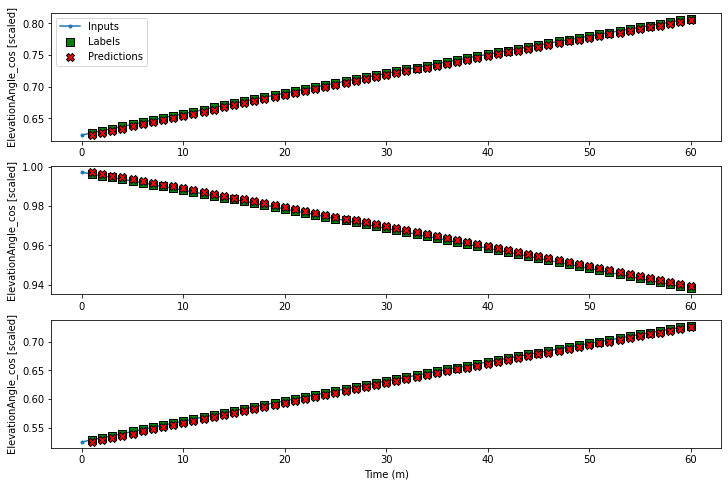

In [39]:
mo_wide_window.plot(mo_baseline_last)

#plt.savefig('figures/CH13_F12_peixeiro.png', dpi=300)

In [40]:
# mo_wide_window.plot(model=mo_baseline_last, plot_col='ElevationAngle_sin')

# plt.savefig('figures/CH13_F13_peixeiro.png', dpi=300)

Again, we can print the MAE of our baseline model.

In [41]:
# print(mo_performance['Baseline - Last'][1])

#### Implementing a multi-output linear model

    1. The function takes a model and a window of data from the DataWindow class. The patience is the number of epochs after which the model should stop training if the validation loss does not improve; max_epochs sets a maximum number of epochs to train the model.
    
    2. The validation loss is tracked to determine if we should apply early stopping or not.
    
    3. Early stopping occurs if 3 consecutive epochs do not decrease the validation loss, as set by the patience parameter.
    
    4. The MSE is used as the loss function.
    
    5. The MAE is used as an error metric. This is how we compare the performance of our models. A lower MAE means a better model.
    
    6. The model is fit on the training set.
    
    7. The model can train for at most 50 epochs, as set by the max_epochs parameter.
    
    8. We use the validation set to calculate the validation loss.
    
    9. early_stopping is passed as a callback. If the validation loss does not decrease after 3 consecutive epochs, the model stops training. This avoids overfitting.

In [42]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), 
                  optimizer=Adam(), metrics=[RootMeanSquaredError(), 
                                             MeanAbsoluteError(), 
                                             MeanAbsolutePercentageError()])

    history = model.fit(window.train, epochs=max_epochs, 
                        validation_data=window.val, 
                        callbacks=[early_stopping])
    
    return history

In [43]:
# mo_linear = Sequential([Dense(units=2)])

# history = compile_and_fit(mo_linear, mo_single_step_window)

# mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
# mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=3)

## Implementing a deep neural network

#### Implementing a deep neural network as a multi-output model

In [44]:
mo_dense = Sequential([Dense(units=32, activation='relu'), 
                       Dense(units=32, activation='relu'), 
                       Dense(units=2)])

In [45]:
# history = compile_and_fit(mo_dense, mo_single_step_window)

# mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
# mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=3)

In [46]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('Mean absolute error')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val):plt.text(x=index - 0.15, 
#                                                    y=value+0.00005, s=str(round(value, 5)), 
#                                                    ha='center')
    
# for index, value in enumerate(mo_mae_test): plt.text(x=index + 0.15, 
#                                                      y=value+0.00005, 
#                                                      s=str(round(value, 6)), ha='center')

# plt.ylim(0, 0.003)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()

### Implementing the LSTM architecture

#### Implementing an LSTM as a multi-output model

In [47]:
mo_wide_window = DataWindow(input_width=60, label_width=60, shift=1, label_columns=['ElevationAngle_sin','ElevationAngle_cos'])

In [48]:
mo_lstm_model = Sequential([LSTM(32, return_sequences=True), Dense(units = 2)])

In [49]:
history = compile_and_fit(mo_lstm_model, mo_wide_window)

# # mo_val_performance = {}
# # mo_performance = {}

# mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
# mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

mo_val_performance = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
2583/2583 [==============================] - 35s 11ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - mean_absolute_error: 0.0223 - mean_absolute_percentage_error: 1028.5538 - val_loss: 1.4798e-04 - val_root_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0073 - val_mean_absolute_percentage_error: 266.1479
Epoch 2/50
2583/2583 [==============================] - 28s 11ms/step - loss: 6.2512e-05 - root_mean_squared_error: 0.0079 - mean_absolute_error: 0.0042 - mean_absolute_percentage_error: 190.1671 - val_loss: 5.0733e-05 - val_root_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0044 - val_mean_absolute_percentage_error: 171.9811
Epoch 3/50
2583/2583 [==============================] - 28s 11ms/step - loss: 1.8795e-05 - root_mean_squared_error: 0.0043 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 124.4175 - val_loss: 1.8689e-05 - val_root_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0026 - val_mean_absolute_percentage_error

In [50]:
# Append the metrics to the list
#metrics_list.append(mo_performance)

# Append the metrics to the dataframe
metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
                                'MAE':mo_performance[2], 'MAPE':mo_performance[3]}, ignore_index=True)


# Print the list of metrics
#print(metrics_list)

metrics_df

,loss,RMSE,MAE,MAPE
0,0.000003,0.001625,0.001326,83.664352
1,0.000002,0.001346,0.001158,37.554096


In [51]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('Mean absolute error')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val): plt.text(x=index - 0.15, 
#                                                     y=value+0.00005, 
#                                                     s=str(round(value, 4)), ha='center')
    
# for index, value in enumerate(mo_mae_test): plt.text(x=index + 0.15, 
#                                                      y=value+0.00005, 
#                                                      s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.003)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()

#### Implementing a CNN

#### Implementing a CNN as a multi-output model

In [52]:
KERNEL_WIDTH2 = 3
LABEL_WIDTH2 = 60
INPUT_WIDTH2 = LABEL_WIDTH2 + KERNEL_WIDTH2 - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH2, label_width=60, shift=1, label_columns=['ElevationAngle_sin','ElevationAngle_cos'])

In [53]:
mo_cnn_model = Sequential([Conv1D(filters=32, 
                                   kernel_size=(KERNEL_WIDTH2,), 
                                   activation='relu'), 
                            Dense(units=32, activation='relu'), 
                            Dense(units=2)])
history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

#mo_val_performance = {}
#mo_performance = {}

# mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
# mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=3)

mo_val_performance = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=3)

Epoch 1/50
2582/2582 [==============================] - 24s 8ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694 - mean_absolute_error: 0.0195 - mean_absolute_percentage_error: 824.5759 - val_loss: 8.0783e-05 - val_root_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0067 - val_mean_absolute_percentage_error: 179.2107
Epoch 2/50
2582/2582 [==============================] - 19s 7ms/step - loss: 2.1220e-05 - root_mean_squared_error: 0.0046 - mean_absolute_error: 0.0034 - mean_absolute_percentage_error: 114.5002 - val_loss: 1.2686e-05 - val_root_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0027 - val_mean_absolute_percentage_error: 75.3066
Epoch 3/50
2582/2582 [==============================] - 19s 7ms/step - loss: 9.5336e-06 - root_mean_squared_error: 0.0031 - mean_absolute_error: 0.0023 - mean_absolute_percentage_error: 85.4602 - val_loss: 7.6103e-06 - val_root_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0022 - val_mean_absolute_percentage_error: 53.0

In [54]:
# Append the metrics to the list
#metrics_list.append(mo_performance)

# Append the metrics to the dataframe
metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
                                'MAE':mo_performance[2], 'MAPE':mo_performance[3]}, ignore_index=True)


# Print the list of metrics
#print(metrics_list)

metrics_df

,loss,RMSE,MAE,MAPE
0,2.640159e-06,0.001625,0.001326,83.664352
1,1.813002e-06,0.001346,0.001158,37.554096
2,9.452504e-07,0.000972,0.000888,126.877068


In [55]:
mo_cnn_lstm_model = Sequential([Conv1D(filters=32, kernel_size=(KERNEL_WIDTH2,), 
                                       activation='relu'), LSTM(32, return_sequences=True), 
                                Dense(units=2)])
history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)
# mo_val_performance['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.val)
# mo_performance['CNN + LSTM'] = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.test, verbose=3)

mo_val_performance = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.val)
mo_performance = mo_cnn_lstm_model.evaluate(wide_mo_conv_window.test, verbose=3)

Epoch 1/50
2582/2582 [==============================] - 31s 11ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 597.8447 - val_loss: 4.1326e-05 - val_root_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0048 - val_mean_absolute_percentage_error: 203.2401
Epoch 2/50
2582/2582 [==============================] - 28s 11ms/step - loss: 1.7588e-05 - root_mean_squared_error: 0.0042 - mean_absolute_error: 0.0031 - mean_absolute_percentage_error: 144.9839 - val_loss: 9.8437e-06 - val_root_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0022 - val_mean_absolute_percentage_error: 113.2696
Epoch 3/50
2582/2582 [==============================] - 28s 11ms/step - loss: 1.1261e-05 - root_mean_squared_error: 0.0034 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 103.8330 - val_loss: 5.5846e-06 - val_root_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0017 - val_mean_absolute_percentage_error:

In [56]:
# Append the metrics to the list
#metrics_list.append(mo_performance)

# Append the metrics to the dataframe
metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
                                'MAE':mo_performance[2], 'MAPE':mo_performance[3]}, ignore_index=True)


# Print the list of metrics
#print(metrics_list)

metrics_df

,loss,RMSE,MAE,MAPE
0,2.640159e-06,0.001625,0.001326,83.664352
1,1.813002e-06,0.001346,0.001158,37.554096
2,9.452504e-07,0.000972,0.000888,126.877068
3,1.390918e-06,0.001179,0.000990,129.915237


In [57]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.15, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.15, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('Mean absolute error')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val):
#      plt.text(x=index - 0.15, y=value+0.00005, s=str(round(value, 4)), 
#               ha='center')
    
# for index, value in enumerate(mo_mae_test):
#      plt.text(x=index + 0.15, y=value+0.00005, 
#               s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.0055)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()

In [58]:
# for name, value in mo_performance.items(): 
#     print(f'{name:8s}: {value[1]:0.4f}')

In [59]:
# mo_wide_window = DataWindow(input_width=60, label_width=60, shift=1, label_columns=['ElevationAngle_sin','ElevationAngle_cos'])

In [60]:
# mo_lstm_model1 = Sequential([LSTM(32, return_sequences=True), 
#                              LSTM(32, return_sequences=True), 
#                              Dense(units = 2)])

In [61]:
# history = compile_and_fit(mo_lstm_model1, mo_wide_window)

# # # mo_val_performance = {}
# # # mo_performance = {}

# mo_val_performance['LSTM1'] = mo_lstm_model1.evaluate(mo_wide_window.val)
# mo_performance['LSTM1'] = mo_lstm_model1.evaluate(mo_wide_window.test, verbose=0)

In [62]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('Mean absolute error')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val):
#     plt.text(x=index - 0.15, y=value+0.00005, s=str(round(value, 4)), 
#              ha='center')
    
# for index, value in enumerate(mo_mae_test):
#     plt.text(x=index + 0.15, y=value+0.00005, 
#              s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.003)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()

In [63]:
# KERNEL_WIDTH2 = 3
# LABEL_WIDTH2 = 60
# INPUT_WIDTH2 = LABEL_WIDTH2 + KERNEL_WIDTH2 - 1

# wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH2, label_width=60, shift=1, label_columns=['ElevationAngle_sin','ElevationAngle_cos'])

In [64]:
# mo_cnn_lstm_model1 = Sequential([Conv1D(filters=32, 
#                                        kernel_size=(KERNEL_WIDTH2), 
#                                        activation='relu'), 
#                                 LSTM(24, return_sequences=True), 
#                                 Dense(units=2)])
# history = compile_and_fit(mo_cnn_lstm_model1, wide_mo_conv_window)
# # mo_val_performance['CNN + LSTM1'] = mo_cnn_lstm_model1.evaluate(wide_mo_conv_window.val)
# # mo_performance['CNN + LSTM1'] = mo_cnn_lstm_model1.evaluate(wide_mo_conv_window.test, verbose=3)

# mo_val_performance = mo_cnn_lstm_model1.evaluate(wide_mo_conv_window.val)
# mo_performance = mo_cnn_lstm_model1.evaluate(wide_mo_conv_window.test, verbose=3)

Epoch 1/50
2582/2582 [==============================] - 31s 11ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 699.1631 - val_loss: 3.6913e-05 - val_root_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0044 - val_mean_absolute_percentage_error: 248.7540
Epoch 2/50
2582/2582 [==============================] - 29s 11ms/step - loss: 1.6963e-05 - root_mean_squared_error: 0.0041 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 140.0233 - val_loss: 9.3233e-06 - val_root_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0020 - val_mean_absolute_percentage_error: 115.4345
Epoch 3/50
2582/2582 [==============================] - 28s 11ms/step - loss: 1.0025e-05 - root_mean_squared_error: 0.0032 - mean_absolute_error: 0.0023 - mean_absolute_percentage_error: 103.6560 - val_loss: 6.3894e-06 - val_root_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0018 - val_mean_absolute_percentage_error:

In [65]:
# # Append the metrics to the list
# #metrics_list.append(mo_performance)

# # Append the metrics to the dataframe
# metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
#                                 'MAE':mo_performance[2], 'MAPE':mo_performance[3]}, ignore_index=True)


# # Print the list of metrics
# #print(metrics_list)

# metrics_df

,loss,RMSE,MAE,MAPE
0,2.640159e-06,0.001625,0.001326,83.664352
1,1.813002e-06,0.001346,0.001158,37.554096
2,9.452504e-07,0.000972,0.000888,126.877068
3,1.390918e-06,0.001179,0.000990,129.915237
4,1.642828e-06,0.001282,0.001070,62.250504


In [66]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.15, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.15, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('Mean absolute error')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val):
#     plt.text(x=index - 0.15, y=value+0.00005, s=str(round(value, 4)), 
#              ha='center')
    
# for index, value in enumerate(mo_mae_test):
#     plt.text(x=index + 0.15, y=value+0.00005, 
#              s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.0055)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()

In [67]:
# for name, value in mo_performance.items():
#     print(f'{name:8s}: {value[1]:0.4f}')

In [68]:
# KERNEL_WIDTH = 6
# LABEL_WIDTH = 60
# INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
# initializer = tf.keras.initializers.HeNormal()

# wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=60, shift=1, label_columns=['ElevationAngle_sin','ElevationAngle_cos'])

In [69]:
# mo_cnn_lstm_model2 = Sequential([Conv1D(filters=32, 
#                                        kernel_size=(KERNEL_WIDTH), 
#                                        activation='relu'), 
#                                 LSTM(24, activation='tanh', return_sequences=True), 
#                                 Dense(units=2)])
# history = compile_and_fit(mo_cnn_lstm_model2, wide_mo_conv_window)
# # mo_val_performance['CNN + LSTM2'] = mo_cnn_lstm_model2.evaluate(wide_mo_conv_window.val)
# # mo_performance['CNN + LSTM2'] = mo_cnn_lstm_model2.evaluate(wide_mo_conv_window.test, verbose=3)

# mo_val_performance = mo_cnn_lstm_model2.evaluate(wide_mo_conv_window.val)
# mo_performance = mo_cnn_lstm_model2.evaluate(wide_mo_conv_window.test, verbose=3)

Epoch 1/50
2582/2582 [==============================] - 31s 11ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 595.4604 - val_loss: 2.7095e-05 - val_root_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0036 - val_mean_absolute_percentage_error: 209.7556
Epoch 2/50
2582/2582 [==============================] - 29s 11ms/step - loss: 1.8719e-05 - root_mean_squared_error: 0.0043 - mean_absolute_error: 0.0032 - mean_absolute_percentage_error: 224.9503 - val_loss: 3.3049e-05 - val_root_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0050 - val_mean_absolute_percentage_error: 228.6836
Epoch 3/50
2582/2582 [==============================] - 28s 11ms/step - loss: 1.2206e-05 - root_mean_squared_error: 0.0035 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 190.4556 - val_loss: 8.8069e-06 - val_root_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0023 - val_mean_absolute_percentage_error:

In [70]:
# # Append the metrics to the list
# #metrics_list.append(mo_performance)

# # Append the metrics to the dataframe
# metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
#                                 'MAE':mo_performance[2], 'MAPE':mo_performance[3]}, ignore_index=True)


# # Print the list of metrics
# #print(metrics_list)

# metrics_df

,loss,RMSE,MAE,MAPE
0,2.640159e-06,0.001625,0.001326,83.664352
1,1.813002e-06,0.001346,0.001158,37.554096
2,9.452504e-07,0.000972,0.000888,126.877068
3,1.390918e-06,0.001179,0.000990,129.915237
4,1.642828e-06,0.001282,0.001070,62.250504
5,1.112630e-06,0.001055,0.000849,47.071808


In [71]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.15, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.15, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('Mean absolute error')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val):
#     plt.text(x=index - 0.15, y=value+0.00005, s=str(round(value, 4)), 
#              ha='center')
    
# for index, value in enumerate(mo_mae_test):
#     plt.text(x=index + 0.15, y=value+0.00005, 
#              s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.0055)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()

In [72]:
# KERNEL_WIDTH = 6
# LABEL_WIDTH = 60
# INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
# initializer = tf.keras.initializers.HeNormal()

# wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=60, shift=1, label_columns=['ElevationAngle_sin','ElevationAngle_cos'])

In [73]:
# mo_cnn_lstm_model3 = Sequential([Conv1D(filters=32, 
#                                        kernel_size=(KERNEL_WIDTH), 
#                                        activation='relu'), 
#                                 LSTM(32, activation='tanh', return_sequences=True), 
#                                 Dense(units=2)])
# history = compile_and_fit(mo_cnn_lstm_model3, wide_mo_conv_window)
# # mo_val_performance['CNN + LSTM3'] = mo_cnn_lstm_model3.evaluate(wide_mo_conv_window.val)
# # mo_performance['CNN + LSTM3'] = mo_cnn_lstm_model3.evaluate(wide_mo_conv_window.test, verbose=3)

# mo_val_performance = mo_cnn_lstm_model3.evaluate(wide_mo_conv_window.val)
# mo_performance = mo_cnn_lstm_model3.evaluate(wide_mo_conv_window.test, verbose=3)

Epoch 1/50
2582/2582 [==============================] - 30s 11ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 532.9967 - val_loss: 3.0668e-05 - val_root_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0038 - val_mean_absolute_percentage_error: 100.0253
Epoch 2/50
2582/2582 [==============================] - 28s 11ms/step - loss: 1.8128e-05 - root_mean_squared_error: 0.0043 - mean_absolute_error: 0.0031 - mean_absolute_percentage_error: 153.3733 - val_loss: 1.1207e-05 - val_root_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0023 - val_mean_absolute_percentage_error: 65.2257
Epoch 3/50
2582/2582 [==============================] - 29s 11ms/step - loss: 1.1670e-05 - root_mean_squared_error: 0.0034 - mean_absolute_error: 0.0025 - mean_absolute_percentage_error: 133.5648 - val_loss: 6.2386e-06 - val_root_mean_squared_error: 0.0025 - val_mean_absolute_error: 0.0018 - val_mean_absolute_percentage_error: 

In [74]:
# # Append the metrics to the list
# #metrics_list.append(mo_performance)

# # Append the metrics to the dataframe
# metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
#                                 'MAE':mo_performance[2], 'MAPE':mo_performance[3]}, ignore_index=True)


# # Print the list of metrics
# #print(metrics_list)

# metrics_df

,loss,RMSE,MAE,MAPE
0,2.640159e-06,0.001625,0.001326,83.664352
1,1.813002e-06,0.001346,0.001158,37.554096
2,9.452504e-07,0.000972,0.000888,126.877068
3,1.390918e-06,0.001179,0.000990,129.915237
4,1.642828e-06,0.001282,0.001070,62.250504
5,1.112630e-06,0.001055,0.000849,47.071808
6,5.511184e-07,0.000742,0.000546,55.439575


In [75]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.15, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.15, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('RootMeanSquaredError')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val):
#     plt.text(x=index - 0.15, y=value+0.00005, s=str(round(value, 4)), 
#              ha='center')
    
# for index, value in enumerate(mo_mae_test):
#     plt.text(x=index + 0.15, y=value+0.00005, 
#              s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.0055)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()

In [76]:
# for name, value in mo_performance.items():
#     print(f'{name:8s}: {value[1]:0.4f}')

In [77]:
mo_gru_model = Sequential([GRU(32, return_sequences=True), 
                           Dense(units = 2)])

history = compile_and_fit(mo_gru_model, mo_wide_window)

# # mo_val_performance = {}
# # mo_performance = {}

# mo_val_performance['GRU'] = mo_gru_model.evaluate(mo_wide_window.val)
# mo_performance['GRU'] = mo_gru_model.evaluate(mo_wide_window.test, verbose=0)

mo_val_performance = mo_gru_model.evaluate(mo_wide_window.val)
mo_performance = mo_gru_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
2583/2583 [==============================] - 28s 10ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - mean_absolute_error: 0.0192 - mean_absolute_percentage_error: 982.2224 - val_loss: 9.2148e-05 - val_root_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0058 - val_mean_absolute_percentage_error: 255.7061
Epoch 2/50
2583/2583 [==============================] - 25s 10ms/step - loss: 2.7064e-05 - root_mean_squared_error: 0.0052 - mean_absolute_error: 0.0031 - mean_absolute_percentage_error: 171.7381 - val_loss: 2.2836e-05 - val_root_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0031 - val_mean_absolute_percentage_error: 92.0444
Epoch 3/50
2583/2583 [==============================] - 25s 10ms/step - loss: 9.6936e-06 - root_mean_squared_error: 0.0031 - mean_absolute_error: 0.0022 - mean_absolute_percentage_error: 108.3915 - val_loss: 2.7357e-05 - val_root_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0044 - val_mean_absolute_percentage_error: 

In [78]:
# Append the metrics to the list
#metrics_list.append(mo_performance)

# Append the metrics to the dataframe
metrics_df = metrics_df.append({'loss':mo_performance[0], 'RMSE':mo_performance[1], 
                                'MAE':mo_performance[2], 'MAPE':mo_performance[3]}, ignore_index=True)


# Print the list of metrics
#print(metrics_list)

metrics_df

,loss,RMSE,MAE,MAPE
0,2.640159e-06,0.001625,0.001326,83.664352
1,1.813002e-06,0.001346,0.001158,37.554096
2,9.452504e-07,0.000972,0.000888,126.877068
3,1.390918e-06,0.001179,0.000990,129.915237
4,1.642828e-06,0.001282,0.001070,62.250504
5,1.112630e-06,0.001055,0.000849,47.071808
6,5.511184e-07,0.000742,0.000546,55.439575
7,3.266050e-06,0.001807,0.001667,39.951611


In [79]:
# for name, value in mo_performance.items():
#     print(f'{name:8s}: {value[1]:0.4f}')

In [80]:
# mo_cnn_GRU_model = Sequential([Conv1D(filters=32, 
#                                        kernel_size=(KERNEL_WIDTH), 
#                                        activation='relu'), 
#                                 GRU(32, activation='tanh', return_sequences=True), 
#                                 Dense(units=2)])
# history = compile_and_fit(mo_cnn_GRU_model, wide_mo_conv_window)
# mo_val_performance['CNN + GRU'] = mo_cnn_GRU_model.evaluate(wide_mo_conv_window.val)
# mo_performance['CNN + GRU'] = mo_cnn_GRU_model.evaluate(wide_mo_conv_window.test, verbose=3)

In [81]:
# for name, value in mo_performance.items():
#     print(f'{name:8s}: {value[1]:0.4f}')

In [82]:
# mo_rnn_model = Sequential([SimpleRNN(32, return_sequences=True), 
#                            Dense(units = 2)])

# history = compile_and_fit(mo_rnn_model, mo_wide_window)

# # # mo_val_performance = {}
# # # mo_performance = {}

# mo_val_performance['RNN'] = mo_rnn_model.evaluate(mo_wide_window.val)
# mo_performance['RNN'] = mo_rnn_model.evaluate(mo_wide_window.test, verbose=0)

In [83]:
# mo_cnn_rnn_model = Sequential([Conv1D(filters=32, 
#                                        kernel_size=(KERNEL_WIDTH), 
#                                        activation='relu'), 
#                                 SimpleRNN(32, activation='tanh', return_sequences=True), 
#                                 Dense(units=2)])
# history = compile_and_fit(mo_cnn_rnn_model, wide_mo_conv_window)
# mo_val_performance['CNN + RNN'] = mo_cnn_rnn_model.evaluate(wide_mo_conv_window.val)
# mo_performance['CNN + RNN'] = mo_cnn_rnn_model.evaluate(wide_mo_conv_window.test, verbose=3)

In [84]:
# mo_mae_val = [v[1] for v in mo_val_performance.values()]
# mo_mae_test = [v[1] for v in mo_performance.values()]

# x = np.arange(len(mo_performance))

# fig, ax = plt.subplots()
# ax.bar(x - 0.15, mo_mae_val, width=0.15, color='black', edgecolor='black', label='Validation')
# ax.bar(x + 0.15, mo_mae_test, width=0.15, color='white', edgecolor='black', hatch='/', label='Test')
# ax.set_ylabel('RootMeanSquaredError')
# ax.set_xlabel('Models')

# for index, value in enumerate(mo_mae_val):
#     plt.text(x=index - 0.15, y=value+0.00005, s=str(round(value, 4)), 
#              ha='center')
    
# for index, value in enumerate(mo_mae_test):
#     plt.text(x=index + 0.15, y=value+0.00005, 
#              s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.0055)
# plt.xticks(ticks=x, labels=mo_performance.keys())
# plt.legend(loc='best')
# plt.tight_layout()